M2L School 2025 Edition, Milan, Italy.

This tutorial reuses material from:
*   Explanations and code snippets from the [2023 edition](https://github.com/M2Lschool/tutorials2024/).

Notebook Author: Matteo Hessel.



---
# RL02: Deep RL with Policy Gradient methods.
---

Welcome to the second part of the RL Lab @ M2L 2025!

This notebook introduces you to a fundamental concept in reinforcement learning: **Policy Gradient Methods**. Why should we care? Many real-world problems involve continuous action spaces or complex environments where value-based methods struggle to succeed. Policy gradient methods offer an alternative approach by directly parametrising and learning the policy, making them powerful tools for these kinds of challenges.

Our goal in this notebook is to take you step-by-step through the process of building and training an agent using policy gradient methods and neural networks. By the end, you'll be able to implement a neural network that learns a policy to solve classic control tasks. Here is what this journey will involve:

- **Exploring Policy Gradients**: We'll introduce you to the core ideas behind policy gradient methods and why they're a natural fit for problems where traditional RL methods fall short.
- **Neural Network as Policy Approximators**: Learn how deep neural networks can be used to approximate the policy, enabling agents to navigate complex environments.
- **Implementing the REINFORCE (and more) Algorithm**: You'll code the REINFORCE algorithm, one of the most widely used policy gradient methods.
- **Training an Agent in a Classic Control Environment**: Finally, we'll put everything together and train an agent to master a classic control environment using your own implementation.

The exercises and explanations provided here are designed to merge theoretical understanding with practical coding. By the time you finish, you'll have hands-on experience with policy gradient methods and their applications in reinforcement learning.



In [1]:
#@title Install dependecies
!pip install gymnasium

In [2]:
#@title Imports
import numpy as np
np.bool8 = np.bool

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc
import seaborn as sns
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import one_hot
import torch.optim as optim
from torch.distributions import Categorical
import gym

# making plots pretty
sns.set_palette("deep")
rc('animation', html='jshtml')
import warnings
warnings.filterwarnings('ignore')

# for reproducibility's sake!
random.seed(42)
torch.manual_seed(42)
print(gym.__version__)

0.25.2


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
#@title Some helper functions

def evaluate(env, policy, gamma=1., num_episodes=100):
    """
    Evaluate a RL agent
    :param env: (Env object) the Gym environment
    :param policy: (BasePolicy object) the policy in stable_baselines3
    :param gamma: (float) the discount factor
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    all_episode_rewards = []
    for i in range(num_episodes): # iterate over the episodes
        episode_rewards = []
        done = False
        discounter = 1.
        obs = env.reset()
        frames = []
        while not done: # iterate over the steps until termination
            action = policy.draw_action(obs)
            obs, reward, terminated, truncated = env.step(action)
            done = terminated or truncated
            episode_rewards.append(reward * discounter) # compute discounted reward
            discounter *= gamma
            frames.append(env.render(mode="rgb_array"))

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    std_episode_reward = np.std(all_episode_rewards) / np.sqrt(num_episodes - 1)
    print("Mean reward:", mean_episode_reward,
          "Std reward:", std_episode_reward,
          "Num episodes:", num_episodes)

    return mean_episode_reward, std_episode_reward, frames



def plot_results(results):
    """
    Plot the results of the experiments
    :param results: (list of tuples) each tuple contains the mean and std of the return
    """

    plt.figure()

    _mean = []
    _std = []
    for m, s, _ in results:
        _mean.append(m)
        _std.append(s)

    _mean = np.array(_mean)
    _std = np.array(_std)

    ts = np.arange(len(_mean))
    plt.plot(ts, _mean)
    plt.fill_between(ts, _mean-_std, _mean+_std, alpha=.2)

    plt.xlabel('Trajectories')
    plt.ylabel('Average return')
    plt.legend(loc='lower right')

    plt.show()


def collect_rollouts(env, policy, m, T):
    """
    Collects m rollouts by running the policy in the
        environment
    :param env: (Env object) the Gym environment
    :param policy: (Policy object) the policy
    :param gamma: (float) the discount factor
    :param m: (int) number of episodes per iterations
    :param K: (int) maximum number of iterations
    :param theta0: (ndarray) initial parameters (d,)
    :param alpha: (float) the constant learning rate
    :param T: (int) the trajectory horizon
    :return: (list of lists) one list per episode
                each containing triples (s, a, r)
    """

    ll = []
    for j in range(m):
        s = env.reset()
        t = 0
        done = False
        l = []
        while t < T and not done:
            a = policy.draw_action(s)
            s1, r, done, _ = env.step(a)
            l.append((s, a, r))
            s = s1
            t += 1
        ll.append(l)
    return ll

def animate(data, interval=200):
  fig = plt.figure(1)
  img = plt.imshow(data[0][0])
  plt.axis('off')

  def animate(i):
    img.set_data(data[i][0])

  anim = animation.FuncAnimation(fig, animate, frames=len(data), interval=interval)
  plt.close(1)
  return anim

# Recap from first part

- An **environment** represent the task or the problem that we are trying to solve. Our agent directly interacts with the environment through an **action** collecting a **reward**, which will drive the learning process, and observing the variation of the **state**.
- An **episode** (also called **trajectory** or **rollout**) refers to the sequence of states, actions and rewards an agent experiences as it interacts with the environment over time.

In [4]:
env_id = "CartPole-v1"

# Create the env
env = gym.make(env_id, render_mode="rgb_array")

# Create the evaluation env
eval_env = gym.make(env_id, render_mode="rgb_array")

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("Observation space \n")
print("The State Space size is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

print("Action space \n")
print("The Action Space size is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action

Observation space 

The State Space size is:  4
Sample observation [-3.4251311e+00 -2.3349915e+38 -4.8849441e-02  8.0015358e+37]
Action space 

The Action Space size is:  2
Action Space Sample 1


# Introduction to Policy Gradient RL

## Policies

In reinforcement learning (RL), a **policy** defines the behavior of an agent by mapping states to actions. It determines how the agent makes decisions at each time step while interacting with the environment. Formally, a policy $\pi$ is a function that takes a state as inpunt and returns an action.
We distinguish two types of policies:
- **Deterministic Policy**: Always returns the same action for a given state.

$$
  a = \pi(s)
$$

- **Stochastic Policy**: Returns a probability distribution over possible actions. The agent samples an action from this distribution.

$$
  \pi(a | s) = P(a | s)
$$

In stochastic policies, $\pi(a∣s)$ represents the probability of taking action $a$ given the state $s$.

A stochastic policy can be directly parametrised by a function with paramethers $\theta$ mapping states to action probabilities: so that the actions of the agent in each state are sampled from some distribution $\pi_\theta(a|s)$. For instance such function may be parametrised by a neural network with parameters $\theta$.

## Policy Gradient methods

Policy gradient methods aim to learn the stochastic policy mapping states to action probabilities by interacting with the environment and updating the parameters of the policy based on the observed rewards. To do so we need a loss function or *objective*. In RL, the general objective is to maximise the expected episode return when taking actions in the environment according to the policy.  So, the task of a policy gradient method will be to update the neural network parameters $\theta$ so as to maximise:

$$J(\pi_\theta)=\mathrm{E}_{\tau\sim\pi_\theta}\ [R(\tau)],$$

where $\mathrm{E}$ denotes that we take the *expectation* over the states that we could be in, and the actions that we could pick in those states, $\tau$ is again shorthand for episode, and $R(\tau)$ denotes the return of episode $\tau$. One way to then find the parameters $\theta$ that maximise such objective $J(\pi_\theta)$  is to do so iteratively by performing gradient ascent on $J(\pi_\theta)$ with respect to the parameters $\theta$.

$$\theta_{k+1}=\theta_k + \alpha \nabla J(\pi_\theta)|_{\theta_{k}},$$

where $\nabla J(\pi_\theta)|_{\theta_{k}}$ is the gradient of the expected return with respect to the policy parameters $\theta_k$ and $\alpha$ is the step size. This quantity, $\nabla J(\pi_\theta)$, is also called the **policy gradient**. If we can compute the policy gradient, then we will have a means by which to directly optimise our policy. Luckily, as it turns out, there is a [way](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html) for us to compute the policy gradient as:


$$\nabla_{\theta} J(\pi_{\theta})=\underset{\tau \sim \pi_{\theta}}{\mathrm{E}}[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t}) R(\tau)].$$

Where $\nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t})$ is called the *score*.


## Softmax Policies

In particular, we will consider **softmax policy**. A softmax policy is a type of stochastic policy where the neural network predicts for each action an un-normalised *preference* $h_\theta(s,a)$. The probability of each action $a$ is then calculated as:

$$
  \pi(a|s) = \frac{\exp(h_\theta(s,a))}{\sum_{a^\prime}\exp(h_\theta(s,a^\prime))}
$$

For such class of policies, we can then compute the *score* of a softmax policy as:


$$
\begin{aligned}
\nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}(a \mid s) & =\nabla_{\boldsymbol{\theta}} h_{\boldsymbol{\theta}}(s, a)-\nabla_{\boldsymbol{\theta}} \log \sum_{a^{\prime} \in A} \exp \left(h_{\boldsymbol{\theta}}\left(s, a^{\prime}\right) \right) \\
& =\nabla_{\boldsymbol{\theta}} h_{\boldsymbol{\theta}}(s, a)-\frac{\sum_{a^{\prime} \in A} \nabla_{\boldsymbol{\theta}} \exp \left(h_{\boldsymbol{\theta}}\left(s, a^{\prime}\right)\right)}{\sum_{a^{\prime} \in A} \exp \left(h_{\boldsymbol{\theta}}\left(s, a^{\prime}\right)\right)} \\
& =\nabla_{\boldsymbol{\theta}} h_{\boldsymbol{\theta}}(s, a)-\sum_{a^{\prime} \in A} \frac{\exp \left(h_{\boldsymbol{\theta}}\left(s, a^{\prime}\right)\right)}{\sum_{a^{\prime \prime} \in A} \exp \left(h_{\boldsymbol{\theta}}\left(s, a^{\prime \prime}\right)\right)} \nabla_{\boldsymbol{\theta}} h_{\boldsymbol{\theta}}\left(s, a^{\prime}\right) \\
& =\left(\nabla_{\boldsymbol{\theta}} h_{\boldsymbol{\theta}}(s, a)-\underset{a^{\prime} \sim \pi_{\boldsymbol{\theta}}(\cdot \mid s)}{\mathbb{E}}\left[\nabla_{\boldsymbol{\theta}} h_{\boldsymbol{\theta}}\left(s, a^{\prime}\right)\right]\right)
\end{aligned}
$$


In the next cell we will implement a policy network with a softmax output.

## ⭐ Exercise

1) **Policy neural network.**
Our policy neural network policy will take the observation as input and passes it through an MLP with `len(num_hiddens)` hidden layers and then outputs one scalar value for each of the possible actions (`2` in CartPole). The outputs of our policy network are the action probabilities provided by a softmax function. Have a look [here](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) to understand how to use a softmax using PyTorch. We will use PyTorch for the neural network training. Please have a look [here](https://pytorch.org/docs/stable/index.html) to understand how PyTorch implements neural network layers and activation functions.

2) **Actor function.**
Next we implement `draw_action` function, which takes network parameters, timestep and random key and returns an action of the policy. Fill in the gaps in the `actor_step` function. Use [`torch.distributions.categorical`](https://pytorch.org/docs/stable/distributions.html#categorical) function to sample an action given the logits.

3) **Compute the gradient log.**
Finally, we implement the function that computes the score function (or gradient log) of the parameters, which we will later use to estimate the policy gradient.


In [5]:
class SoftmaxPolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=16):
        super(SoftmaxPolicyNetwork, self).__init__()
        # -----------------------------------#
        # Define the neural network layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # -----------------------------------#
        self.dim = self.get_parameters().size(dim=0)

    def forward(self, state):
        # -----------------------------------#
        # Forward pass through the network
        x = F.relu(self.fc1(state))
        logits = self.fc2(x)
        action_probs = F.softmax(logits, dim=-1)
        return action_probs
        # -----------------------------------#

    def get_parameters(self):
        return nn.utils.parameters_to_vector(self.parameters()).detach()

    def set_parameters(self, new_params):
        nn.utils.vector_to_parameters(new_params, self.parameters())

    def draw_action(self, state):
        # -----------------------------------#
        # Select an action based on the state using the softmax policy.
        state = torch.FloatTensor(state)
        action_probs = self.forward(state)
        action = Categorical(action_probs).sample().item()

        return action
        # -----------------------------------#

    def grad_log(self, state, action):
        """
        Compute the score function (policy gradient) for a given state and action.

        Args:
            state: A tensor representing the current state (1D).
            action: The action taken (int).

        Returns:
            score: A 1D tensor representing the gradient of the log-probability
                   of the action with respect to the network parameters.
        """
        state = torch.FloatTensor(state)
        action_probs = self.forward(state)

        # -----------------------------------#
        # One-hot encoding of the selected action
        action_one_hot = torch.zeros_like(action_probs)
        action_one_hot[action] = 1

        # Compute the gradient of the log-probability w.r.t logits
        score = action_one_hot - action_probs
        # -----------------------------------#

        # Compute the gradient of the network parameters using chain rule
        # First, we propagate the score through the second layer (fc2)
        fc2_grad_wrt_logits = score.view(-1, 1)  # score is d(log P(a|s)) / d(logits)
        fc2_grad_wrt_weights = torch.matmul(fc2_grad_wrt_logits, F.relu(self.fc1(state)).view(1, -1))  # Chain rule for fc2 weights
        fc2_grad_wrt_bias = fc2_grad_wrt_logits.view(-1)  # Chain rule for fc2 bias

        # Now, we compute the gradient w.r.t. the output of the first layer
        d_fc1_output = torch.matmul(self.fc2.weight.T, score) * (self.fc1(state) > 0).float()  # Backprop through ReLU
        fc1_grad_wrt_weights = torch.matmul(d_fc1_output.view(-1, 1), state.view(1, -1))  # Chain rule for fc1 weights
        fc1_grad_wrt_bias = d_fc1_output.view(-1)  # Chain rule for fc1 bias

        # Concatenate all gradients into a single vector
        score_vector = torch.cat([fc1_grad_wrt_weights.view(-1), fc1_grad_wrt_bias.view(-1),
                                  fc2_grad_wrt_weights.view(-1), fc2_grad_wrt_bias.view(-1)])

        return score_vector

# Policy gradient algorithm

## REINFORCE

REINFORCE is a simple RL algorithm that uses the policy gradient to find the optimal policy by sampling $\nabla_\theta J(\theta)$ and for each set of states and actions considered in each update just increases the probability of choosing the actions (*reinforcing* actions) that were taken proportionally to the cumulative reward observed after taking them.

In REINFORCE we just take the general expression of our gradient of the expected return

$$
\begin{aligned}
\nabla_\theta J(\theta) &= \mathbb{E}_\pi\left[R(\tau) \nabla_\theta \log \pi_\theta\left(A_t \mid S_t\right)\right]
\end{aligned}
$$

and just replaces the expectation over all possible trajectories that the agent could traverse in the environment with the *monte-carlo* sampling of a single trajectory:

$$
\begin{aligned} \widehat{\nabla}_{\theta}^{\text{REINFORCE}} J(\boldsymbol{\theta})
& = \frac{1}{N} \sum_{i=1}^N \nabla_\theta \log \pi_\theta(a_{i} | s_{i})G_i
\end{aligned}
$$

Where $G_i$ represents the **return** (also known as **rewards-to-go**) from step i onwards.

The process is pretty straightforward:

- Initialize the policy parameter $\theta$.
- Generate one trajectory on policy $\pi_\theta$: .
- For t=1, 2, … , T:
  - Estimate the the return $R$;
  - Update policy parameters: $\theta \leftarrow \theta+\alpha \widehat{\nabla}_{\theta}^{\text{REINFORCE}} J(\theta)$

### ⭐ Exercise

In the next cell implement the REINFORCE estimator given the formal definition presented in the previous section.



In [6]:
def reinforce(rollouts, policy, gamma):

    grad = 0

    for roll in rollouts:
        H = len(roll)
        disc_rew = torch.zeros((H, 1))
        scores = torch.zeros((H, policy.dim))

        # -----------------------------------#
        # Retrive the score of the policy and compute the gradient
        for t in range(H):
            s, a, r = roll[t]
            # We use gamma as the discount factor to account for the time it took to get a particular reward.
            # E.G. achieving reward +1 far in the future should be less desirable than achieving reward +1 now.
            disc_rew[t] = gamma ** t * r
            scores[t] = policy.grad_log(s, a)

        cum_scores = torch.cumsum(scores, axis=0)
        grad += torch.sum(cum_scores * disc_rew, axis=0)
        # -----------------------------------#

    return grad / len(rollouts)

# Training loop

Finally, let's run the learning loop.
As the structure of the agent is very similar to Q-learning agent, the learning loop is very similar as well. Notice that we perform a learning step on a batch of samples instead of a single datapoint.

In [7]:

def train(env, policy, gamma, m, K, alpha, T):
    """
    Train a policy
    :param env: (Env object) the Gym environment
    :param policy: (Policy object) the policy
    :param gamma: (float) the discount factor
    :param m: (int) number of episodes per iterations
    :param K: (int) maximum number of iterations
    :param alpha: (float) the constant learning rate
    :param T: (int) the trajectory horizon
    :return: list (ndarray, ndarray) the evaluations
    """

    results = []

    # Evaluate the initial policy
    res = evaluate(env, policy, gamma)
    results.append(res)

    for k in range(K):

        print('Iteration:', k)

        # Generate rollouts
        rollouts = collect_rollouts(env, policy, m, T)

        # Get policy parameter
        theta = policy.get_parameters()

        # Call your Gradient estimator
        pg = reinforce(rollouts, policy, gamma)

        # Update policy parameter
        theta = theta + alpha * pg

        # Set policy parameters
        policy.set_parameters(theta)

        # Evaluate the updated policy
        res = evaluate(env, policy, gamma)
        results.append(res)

    return results

## ⭐ Exercise

- Choose the parameters (number of training episodes, numbers of hidden units in MLP, learning rate, batch size) so that the average return of the agent increases with training and ends up being greater than $100$.
- Run the learning loop and visualise the epsiode returns. Look at the animation of the last episode.

In [8]:
discount_factor = 0.999 # @param
batch_size = 100
iterations = 30 # @param
learning_rate = 0.001 # @param
trajectory_length = 200 # @param
n_hidden = 8 # @param

# Instantiate the policy
policy = SoftmaxPolicyNetwork(s_size, a_size, n_hidden)

# Start training
results = train(env, policy, discount_factor, batch_size, iterations, learning_rate, trajectory_length)

Mean reward: 22.87339613680157 Std reward: 1.0927397980131097 Num episodes: 100
Iteration: 0
Mean reward: 23.84571702606396 Std reward: 1.2130526538888522 Num episodes: 100
Iteration: 1
Mean reward: 24.628164379880783 Std reward: 1.4778604356788123 Num episodes: 100
Iteration: 2
Mean reward: 24.539774074187235 Std reward: 1.353499111803922 Num episodes: 100
Iteration: 3
Mean reward: 26.12533251206386 Std reward: 1.382423997668935 Num episodes: 100
Iteration: 4
Mean reward: 23.9843464570675 Std reward: 1.3442116269438622 Num episodes: 100
Iteration: 5
Mean reward: 22.03978636770967 Std reward: 1.1126927187605873 Num episodes: 100
Iteration: 6
Mean reward: 26.813367955791392 Std reward: 1.5884768753129772 Num episodes: 100
Iteration: 7
Mean reward: 26.16865078614233 Std reward: 1.5971455023865737 Num episodes: 100
Iteration: 8
Mean reward: 27.01251817401044 Std reward: 1.5017625351539816 Num episodes: 100
Iteration: 9
Mean reward: 30.95943209848614 Std reward: 1.7610437824958645 Num epis

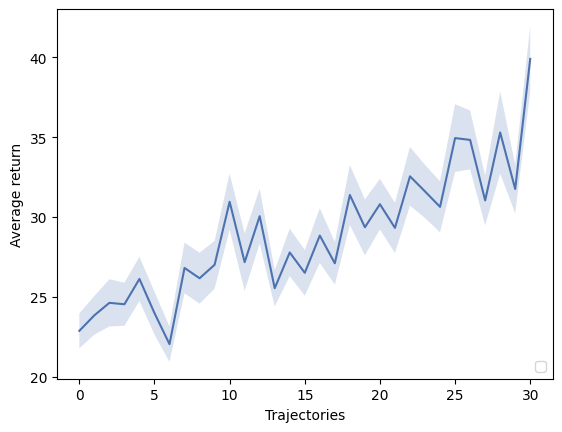

In [9]:
# Plot the results of the training
plot_results(results)

In [10]:
# Evaluate the policy and animate the results
perf_mean, perf_std, frames = evaluate(eval_env, policy, num_episodes=1)

# Animate the last episode
animate(frames)

Mean reward: 28.0 Std reward: nan Num episodes: 1


# Extensions

There is a large literature improving the previously described algorithm along different dimensions

### Variance reduction:

Policy gradient updates can be high variance because they depend on the sampled Monte Carlo return. To reduce variance it's usually a good idea to subtract a baseline

$$
\begin{aligned} \widehat{\nabla}_{\theta}^{\text{REINFORCE}} J(\boldsymbol{\theta})
& = \frac{1}{N} \sum_{i=1}^N (G_i - b_i(s_i)) \nabla_\theta \log \pi_\theta(a_{i} | s_{i})
\end{aligned}
$$

Interestingly, this is a valid update for any choice of $b_i(s)$ as long as it depends only on the state and not the action. And for suitable choices of $b_i(s)$ it can reduce the variance. A common choice is to use the value of the state s as baseline. This can be estimated parametrically (e.g. by a learning a value function as in the previous colab). Alternatively, it can be estimated non parametrically (by sampling many trajectories starting in s and using the average return across them as baseline).

The latter approach is what is used in the popular [GRPO](https://arxiv.org/pdf/2402.03300) algorithm.

### Off-policy learning

In their most naive form policy gradient updates require the trajectories to be sampled from the current policy for the gradient to be an unbiased ascent direction of the RL objective. However, for various reason we often have data sampled from a different (e.g. slightly older) policy. In this cases we can modify the naive update by adding importance sampling corrections (see for instance PPO for the most popular instantiation of this concept).

# 🥳 Congratulations on completing the second part of this tutorial, great job!!!

In this part you learnt how policy gradient works and how to combine it with neural networks. Next, we will look into RL for LLMs.